# STDSR Homework 1: T-digest

Daniil Burakov

## References

- [Computing Extremely Accurate Quantiles Using t-Digests](https://github.com/tdunning/t-digest/blob/main/docs/t-digest-paper/histo.pdf)
- [Berlin Buzzwords 2017: Ted Dunning - Update on the t-digest: Finding Faults in Real Data](https://www.youtube.com/watch?v=Y0eF7SuMQjk)
- [T-Digest: An interesting datastructure to estimate quantiles accurately](https://medium.com/@mani./t-digest-an-interesting-datastructure-to-estimate-quantiles-accurately-b99a50eaf4f7)
- [T-Digest implementation](https://github.com/CamDavidsonPilon/tdigest)

# Algorithm description

Imagine we have a cupcake buiness with thousands of factories around the globe that produce different kinds of cupcakes, and we want to measure a mean production time on subsets of those factories: all factories in Russia, all factories that produce mint cupcakes, etc

Well, we can calculate the average production time at each factory and aggregate all of the averages. Let's check three samples from two different factories:

- **A**lmond cupcakes factory = [30s, 27s, 35s, 24s, 31s]

- **B**utternut cupcakes factory = [25s, 28s, 30s, 33s, 3600s]

- **C**innamon cupcakes factory = [727s, 734s, 726s, 737s, 729s]

Average production time for **A = 29.4s**, for **B = 743.2s**, and for **C = 730.6s**. Why **B** and **C** factories are so slow? It turns out that the **B** factory ran out of flour and needed to refill the flour tank, which delayed the production, while the **C** factory production process requires mandatory 700 second cooling procedure. So, **B** has an outlier and average is very sensitive to them.

Ok, who needs average if we have median?
- **median(A) = 30s**
- **median(B) = 30s**
- **median(C) = 729s**

That's more like it. Let's aggregate medians from other factories then. Oh, wait, medians are non-linear, and we cannot just aggregate them. We need to collect raw samples from all of the factories, sort them, and only then calculate the median. In addition, if new sample arrives, we will have to recalculate it all-over again. Not to mention that we don't have enough RAM on our computer to sort billions of numbers.

We need some trade-off. So, let's trade-off some accuracy for speed. The only thing is, the acltuall allowable trade-off depends on the statistics:

- 50-th percentile +- 0.001% of error -> **overkill**
- 50-th percentile +- 0.1% of error -> **ok**
- 99.999-th percentile +- 0.001% of error -> **ok**
- 99.999-th percentile +- 0.1% of error -> **error is too big**

How to make fast parallel map-reducable online quantile calculation with adjustable errors? With T-digest, of course!

## Cluster and Digest
We have a set $X$ of $N$ samples $X = \{x_1, x_2, \dots, x_N\}$

Let us partition (divide a set into non-empty disjoint subsets, union of which gives the original set) $X$ into subsets aka clusters $C_i  \subseteq X$. Such partition is called a digest $D = \{C_1, C_2, \dots, C_K\}$

Each $C_i$ has two main characteristics:
- $|C|$ - weight, number of elements in the cluster $C$. $|C| > 0$ since $X$ should be properly partitioned (non-empty disjoint subsets)
- $\bar C$ - mean of elements in the cluster $C$. $\bar C = \frac{1}{|C|}\sum_{x \in C} x$

## T-Digest

Now we can sort $C$s using their means as a sorting key. After sorting, we can assign an index to each cluster. Having assigned indices, we can define right and left weights that will be used later:

$$
W_l(C_i) = \sum_{j < i}|C_j| \\
W_r(C_i) = \sum_{j > i}|C_j|
$$

A digest $D$ is a t-digest if it is partially ordered (sorted) and  $\forall C \in D \rightarrow |C| = 1$ or $|C| < S(q, \delta, N)$, where $S(q, \delta, N)$ is a weight bounding function. A t-digest is fully merged if no two consecutive clusters can be combined without breaking the weight bound constraint

## Weight bounding function

Remember our trade-off constraint from above? The weight bounding function defines maximum size of a cluster. So, we can define a bounding function that will define maximum marigin of error for different quantiles by defining the maximum cluster size. One possible example is:

$$
S(q, \delta, N) = 4 * N * \delta * q * (1-q)
$$

It is defined in a way that if $q = 0.5$ and $\delta=1.0$, the value will be equal to $N$ meaning that the cluster for 50-th percentile can contain up to $N$ values. You can play around with different parameters of $N$ and $\delta$ in the cell below. In addition, we will add additional parameter $K$ which will define the maximum number of allowed clusters

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

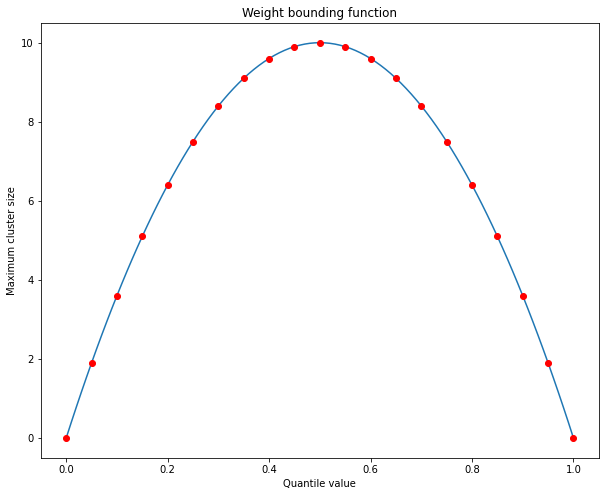

In [ ]:
#@title {run: 'auto'}

N = 10 #@param {type:"slider", min:0, max:100, step:1}
delta = 1.0 #@param {type:"slider", min:0, max:2, step:0.01}

q = np.arange(0.0, 1.01, 0.01)
q_scatter = np.arange(0.0, 1.05, 0.05)
cluster_size = 4 * N * delta * q * (1 - q)
cluster_size_scatter = 4 * N * delta * q_scatter * (1 - q_scatter)

plt.figure(figsize=(10, 8))
plt.plot(q, cluster_size)
plt.scatter(q_scatter, cluster_size_scatter, c='r', zorder=10)
plt.title("Weight bounding function")
plt.xlabel("Quantile value")
plt.ylabel("Maximum cluster size")
plt.show()

## Maintaining a T-digest

Now we have everything to create and maintain a T-digest. Algorithmically, we will use a balanced binary search tree to keep clusters sorted. When a new cluster arrives, we find the nearest existing cluster and check whether we can merge them

### Merging two clusters

To merge $C_1$ with $|C_1| = w_1$ and $\bar C_1 = m_1$ and $C_2$ with $|C_2| = w_2$ and $\bar C_2 = m_2$ into $C$ with with $|C| = w$ and $\bar C = m$  we can use linearity of mean:

$$
w = w_1 + w_2 \\
m = \frac{1}{w_1 + w_2} (\sum_{x_1 \in C_1} x_1 + \sum_{x_2 \in C_2} x_2) =  \frac{1}{w} (w_1 \bar C_1 + w_2 \bar C_2) = \frac{w_1 m_1 + w_2 m_2 + m_1 w_2 - m_1 w_2}{w}  = \frac{m_1 (w_1 + w_2) + w_2 (m_2 - m_1)}{w} = m_1 + \frac{w_2(m_2-m_1)}{w}
$$

## Calculating percentiles

To calculate percentile $p \in [0, 100]$  from a t-digest:
- Convert $p$ into index with $p_i = \frac{Np}{100}$ 
- Go through clusters from left to right and accumulate weight untill total weight is more or equal than $p_i$
- Do linear interpolation between the previous and the current cluster means based on $p_i$

# Implementation


In [ ]:
from typing import List
import time
import random
import numpy as np
import matplotlib.pyplot as plt

## Accumulation tree

AccumulationTree (AT) is a wrapper of Red-Black tree that stores additional information in a node. Here are descriptions of AT methods that were used in TDigest implementation:

- **insert(key, value) -> None** - inserts (key, value pair)
- **pop(key) -> value** - removes the node with key and returns the corresponding value
- **get_left_accumulation(key) -> sum**, returns sum of all values of nodes with keys smaller than k. Will be used as $W_l(C_{key})$
- **min_item() -> (key, value)** - returns (key, value) pair of the leftmost node
- **max_item() -> (key, value)** - returns (key, value) pair of the rightmost node
- **floor_key(key) -> floor_key** - returns the greatest floor_key less than or equal to key
- **ceiling_key(key) -> ceiling_key** - returns the smallest ceiling_key greater than or equal to key


All of the above described methods have complexity $O(log(N))$

In [ ]:
!pip install accumulation-tree

# Wrapper on Red-Black binary search tree that will keep our digest sorted
from accumulation_tree import AccumulationTree

In [ ]:
tree = AccumulationTree(lambda x: x)

N = 11
data = []
for x in range(1, N):
  k = x
  v = 10 * x
  data.append((k, v))
  tree.insert(k, v)

print(f"Original data: {data}")
print()
print(f"Min item: {tree.min_item()}")
print(f"Max item: {tree.max_item()}")
print()
print(f"Left accumulation for -1: {tree.get_left_accumulation(-1)}")
print(f"Left accumulation for 2: {tree.get_left_accumulation(2)}")
print(f"Left accumulation for 9.5: {tree.get_left_accumulation(9.5)}")
print(f"Left accumulation for 11: {tree.get_left_accumulation(11)}")
print()
print(f"Floor key of 2.5: {tree.floor_key(2.5)}")
print(f"Ceiling key of 2.5: {tree.ceiling_key(2.5)}")

Original data: [(1, 10), (2, 20), (3, 30), (4, 40), (5, 50), (6, 60), (7, 70), (8, 80), (9, 90), (10, 100)]

Min item: (1, 10)
Max item: (10, 100)

Left accumulation for -1: 0
Left accumulation for 2: 10
Left accumulation for 9.5: 450
Left accumulation for 11: 550

Floor key of 2.5: 2
Ceiling key of 2.5: 3


## TDigest

In [ ]:
class Cluster():
  def __init__(self, mean: float, weight: int) -> None:
    self._mean = mean
    self._weight = weight

  @property
  def mean(self) -> float:
    return self._mean

  @property
  def weight(self) -> int:
    return self._weight
  
  def add(self, mean: float, weight: int) -> None:
    self._weight += weight
    self._mean += weight * (mean - self._mean) / self._weight

In [ ]:
class TDigest():
  def __init__(self, delta: float = 0.02, K: int = 1000) -> None:
    """
    
    """
    self._cluster_tree = AccumulationTree(lambda cluster: cluster.weight)
    self._N = 0
    self._delta = delta
    self._K = K

  @property
  def cluster_tree(self) -> AccumulationTree:
    return self._cluster_tree

  def __len__(self) -> int:
    return len(self._cluster_tree)

  def __add__(self, other):
    new_t_digest = TDigest(self._delta, self._K)
    clusters = list(self._cluster_tree.values()) + list(other.cluster_tree.values())
    for cluster in random.sample(clusters, len(clusters)):
      new_t_digest.add(cluster.mean, cluster.weight)

    return new_t_digest

  def add_list(self, list_of_means: List[float]) -> None:
    for mean in list_of_means:
      self.add(mean, 1)
    self.compress()

  def add(self, mean: float, weight: int = 1) -> None:
    self._N += weight

    if len(self) == 0:
      self._add_cluster(Cluster(mean, weight))
      return

    nearest_clusters = self._find_nearest_clusters(mean)
    while len(nearest_clusters) != 0 and weight > 0:
      # Since nearest clusters can return two clusters, we will select
      # candidate cluster randomly to avoid skewing the data
      random_index = random.randint(0, len(nearest_clusters) - 1)
      random_cluster = nearest_clusters[random_index]
      
      # Calculate an approximate value of current quantile
      W_l = self._cluster_tree.get_left_accumulation(random_cluster.mean)
      q = (0.5 * random_cluster.weight + W_l) / self._N
      
      # Check if x can be merged into current random cluster
      max_cluster_weight =  self._N * self._delta * 4 * q * (1 - q)
      if random_cluster.weight + weight > max_cluster_weight:
        nearest_clusters.pop(random_index)
        continue
      
      # Merge current cluster with random cluster as much as possible
      self._cluster_tree.pop(random_cluster.mean)
      used_weight = min(weight, max_cluster_weight - random_cluster.weight)      
      random_cluster.add(mean, used_weight)
      self._add_cluster(random_cluster)

      weight -= used_weight
      nearest_clusters.pop(random_index)
    
    # If we could not fully merge current cluster into nearest clusters due to
    # cluster size constraints, add the current cluster as a separate cluster
    if weight > 0:
      self._add_cluster(Cluster(mean, weight))
    
    if len(self) > self._K:
      self.compress()

  def compress(self) -> None:
    new_t_digest = TDigest(self._delta, self._K)
    cur_clusters = list(self._cluster_tree.values())
    for cluster in random.sample(cur_clusters, len(cur_clusters)):
      new_t_digest.add(cluster.mean, cluster.weight)
    
    self._cluster_tree = new_t_digest.cluster_tree

  def get_percentile(self, p: float) -> float:
    if p < 0.0 or p > 100.0:
      return float('NaN') 

    p = self._N * p / 100.0
    if p == 0.0:
      return self._cluster_tree.min_item()[1].mean

    prev_cluster = None
    prev_weight = 0
    for i, cur_cluster in enumerate(self._cluster_tree.values()):
      if i == 0:
          cur_weight = 0.5 * cur_cluster.weight
      else:
          cur_weight = 0.5 * (cur_cluster.weight + prev_cluster.weight)
          total_weight = prev_weight + cur_weight 
          if total_weight >= p:
            # Linear interpolation
            return (cur_cluster.mean * (p - prev_weight) + prev_cluster.mean * (total_weight - p)) / cur_weight
      prev_cluster = cur_cluster
      prev_weight += cur_weight

    return self._cluster_tree.max_item()[1].mean

  def _add_cluster(self, cluster: Cluster) -> None:
    if cluster.mean not in self._cluster_tree:
      self._cluster_tree.insert(cluster.mean, cluster)
    else:
      self._cluster_tree[cluster.mean].add(cluster.mean, cluster.weight)

  def _find_nearest_clusters(self, x: float) -> List[Cluster]:
      try:
          floor_key = self._cluster_tree.floor_key(x)
      except KeyError:
          # If there is no foor key, it means x is smaller than the smallest
          # key in the cluster tree, so min item is nearest
          return [self._cluster_tree.min_item()[1]]
      
      try:
          ceil_key = self._cluster_tree.ceiling_key(x)
      except KeyError:
          # If there is no ceiling key, it means x is larger than the biggest
          # key in the cluster tree, so max item is nearest
          return [self._cluster_tree.max_item()[1]]
      
      abs_floor_distance = abs(x - floor_key)
      abs_ceil_distacne = abs(x - ceil_key)
      if (abs_floor_distance == abs_ceil_distacne) and (ceil_key != floor_key):
          return [self._cluster_tree[ceil_key], self._cluster_tree[floor_key]]
      elif abs_floor_distance < abs_ceil_distacne:
          return [self._cluster_tree[floor_key]]
      else:
          return [self._cluster_tree[ceil_key]]

# Experiments

Time to test our implementation on the almond factory data. We want to know mean production time, the first and the third quartiles, and 1% of outliers

But first we want to run a test to check that the T-digest works:

In [ ]:
#@title
test_data = [i for i in range(1, 101)]
t_digest = TDigest(delta=0.2, K=100)
t_digest.add_list(test_data)

print(f"Test data size: {len(test_data)}")
print(f"T-digest size: {len(t_digest)}")
print()
percentiles = [0, 25, 50, 75, 100]
for percentile in percentiles:
  print(f"Percentile: {percentile} \n\t T-digest: {t_digest.get_percentile(percentile)} \n\t np.precentile: {np.percentile(test_data, percentile)}")

Test data size: 100
T-digest size: 24

Percentile: 0 
	 T-digest: 1 
	 np.precentile: 1.0
Percentile: 25 
	 T-digest: 25.5 
	 np.precentile: 25.75
Percentile: 50 
	 T-digest: 50.5 
	 np.precentile: 50.5
Percentile: 75 
	 T-digest: 76.14285714285714 
	 np.precentile: 75.25
Percentile: 100 
	 T-digest: 100 
	 np.precentile: 100.0


In [ ]:
#@title
test_data = [i for i in range(1, 101)]
t_digest_left = TDigest(delta=0.2, K=100)
t_digest_left.add_list(test_data[:50])

t_digest_right = TDigest(delta=0.2, K=100)
t_digest_right.add_list(test_data[50:])

t_digest = t_digest_left + t_digest_right

print(f"Test data size: {len(test_data)}")
print(f"T-digest size: {len(t_digest)}")
print()
percentiles = [0, 25, 50, 75, 100]
for percentile in percentiles:
  print(f"Percentile: {percentile} \n\t T-digest: {t_digest.get_percentile(percentile)} \n\t np.precentile: {np.percentile(test_data, percentile)}")

Test data size: 100
T-digest size: 23

Percentile: 0 
	 T-digest: 1 
	 np.precentile: 1.0
Percentile: 25 
	 T-digest: 25.5 
	 np.precentile: 25.75
Percentile: 50 
	 T-digest: 50.65625 
	 np.precentile: 50.5
Percentile: 75 
	 T-digest: 75.5 
	 np.precentile: 75.25
Percentile: 100 
	 T-digest: 100 
	 np.precentile: 100.0


Percentile 0.5: 24.896252733844307
Percentile 25: 28.65216586716376
Percentile 50: 29.99659793950769
Percentile 75: 31.33772251632941
Percentile 99.5: 35.147290587334304


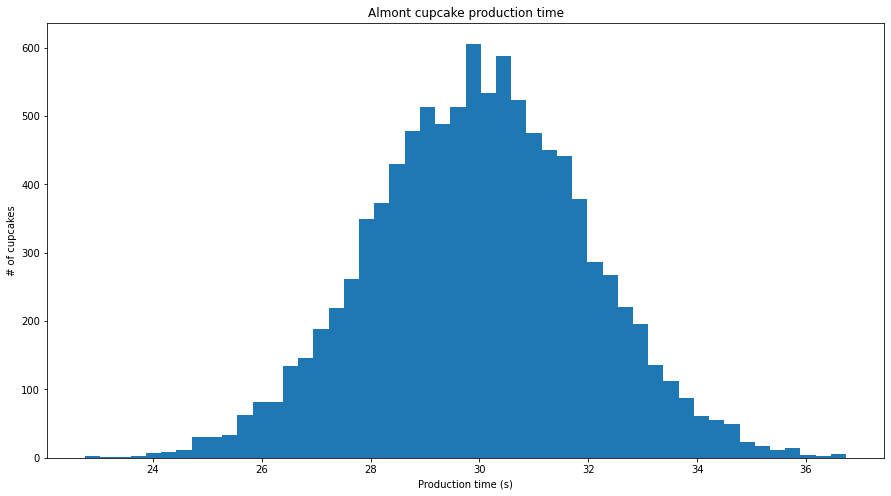

In [ ]:
#@title
mu = 30
sigma = 2
almond_data = np.random.normal(mu, sigma, size=10000)

t_digest = TDigest(delta=0.02, K=1000)
t_digest.add_list(almond_data)

percentiles = [0.5, 25, 50, 75, 99.5]
for percentile in percentiles:
  print(f"Percentile {percentile}: {t_digest.get_percentile(percentile)}")

plt.figure(figsize=(15, 8))
plt.hist(almond_data, 50)
plt.title("Almont cupcake production time")
plt.xlabel("Production time (s)")
plt.ylabel("# of cupcakes")
plt.show()

# Evaluation

Now we benchmark our implementation in terms of error and space consumption. Time consumption cannot be benchmarked here since the algorithm is meant for distributed computation. The only time consumption that can be measured is percentile query time consumption, so we resort to the percentile computation benchmark

Data from uniform and normal distributions was benchmarked

In [ ]:
#@title
def error_benchmark(data, percentiles, delta, K, M=20):
  errors = []
  for i in range(M):
    t_digest = TDigest(delta=delta, K=K)
    t_digest.add_list(data)
  
    cur_errors = []
    for p in percentiles:
      error = abs(t_digest.get_percentile(p) - np.percentile(data, p))
      cur_errors.append(error)
    errors.append(cur_errors)
  errors = np.array(errors)

  plt.figure(figsize=(15, 8))
  plt.boxplot(errors, patch_artist=True, boxprops=dict(facecolor="#0eed7e"))
  plt.xticks([i + 1 for i in range(len(percentiles))], percentiles)
  plt.yscale('log')
  plt.title(f"Error benchmark. Delta: {delta} K: {K} M: {M}")
  plt.xlabel("Percentile (%)")
  plt.ylabel("Error (log scale)")
  plt.show()

  return errors

def space_benchmark(data_sizes, delta, K, M=5):
  digest_sizes = []
  for i in range(M):
    cur_digest_sizes = []
    for data_size in data_sizes:
      t_digest = TDigest(delta=delta, K=K)
      t_digest.add_list(np.random.normal(size=data_size))
      cur_digest_sizes.append(len(t_digest))
    digest_sizes.append(cur_digest_sizes)
  digest_sizes = np.array(digest_sizes)

  plt.figure(figsize=(15, 8))
  plt.boxplot(digest_sizes, patch_artist=True, boxprops=dict(facecolor="#0eed7e"))
  plt.xticks([i + 1 for i in range(len(data_sizes))], data_sizes)
  plt.title(f"Space benchmark. Delta: {delta} K: {K} M: {M}")
  plt.xlabel("Original data size")
  plt.ylabel("T-digest size")
  plt.show()

  return digest_sizes

def percentile_query_time_benchmark(data, percentiles, delta, K, M=10):
  np_query_times = []
  digest_query_times = []
  for i in range(M):
    t_digest = TDigest(delta=delta, K=K)
    t_digest.add_list(data)
    
    cur_np_query_times = []
    cur_digest_query_times = []
    for p in percentiles:
      start_time = time.time()
      np.percentile(data, p)
      cur_np_query_times.append((time.time() - start_time) * 1000.0)
      
      start_time = time.time()
      t_digest.get_percentile(p)
      cur_digest_query_times.append((time.time() - start_time) * 1000.0)
    np_query_times.append(cur_np_query_times)
    digest_query_times.append(cur_digest_query_times)

  np_query_times = np.array(np_query_times)
  digest_query_times = np.array(digest_query_times)

  plt.figure(figsize=(15, 8))
  plt.boxplot(np_query_times, patch_artist=True, boxprops=dict(facecolor="#1770ff"))
  plt.boxplot(digest_query_times, patch_artist=True, boxprops=dict(facecolor="#0eed7e"))
  plt.plot(0, 0, label="T-digest", c="#0eed7e")
  plt.plot(0, 0, label="Numpy", c="#1770ff")
  plt.legend()
  plt.xticks([i + 1 for i in range(len(percentiles))], percentiles)
  plt.title(f"Query time benchmark. Delta: {delta} K: {K} M: {M}")
  plt.xlabel("Percentile (%)")
  plt.ylabel("Calculation time (ms)")
  plt.show()

  return np_query_times, digest_query_times

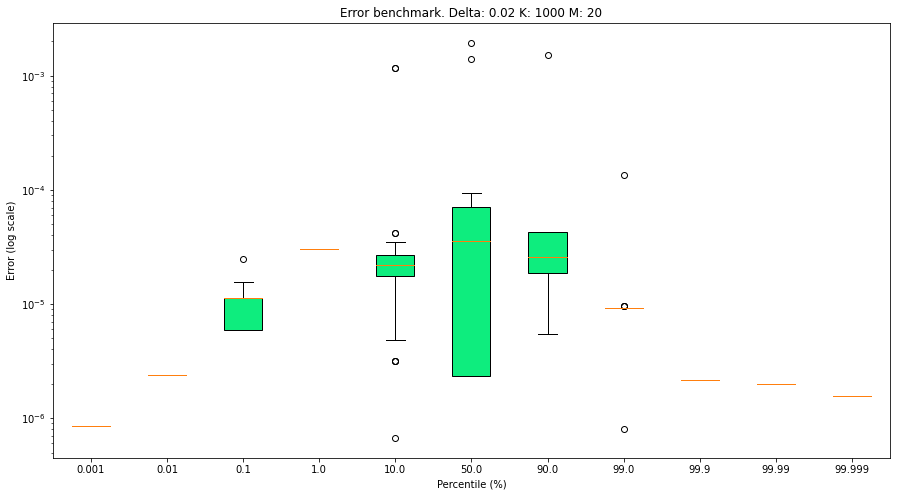

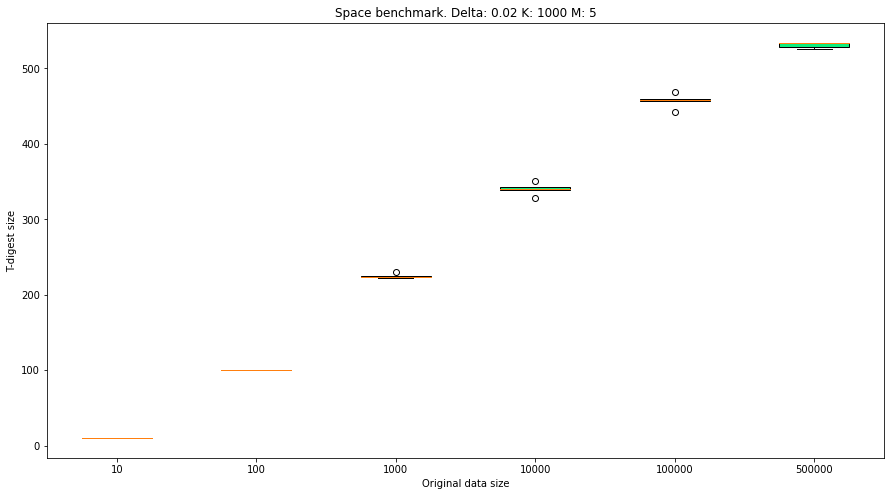

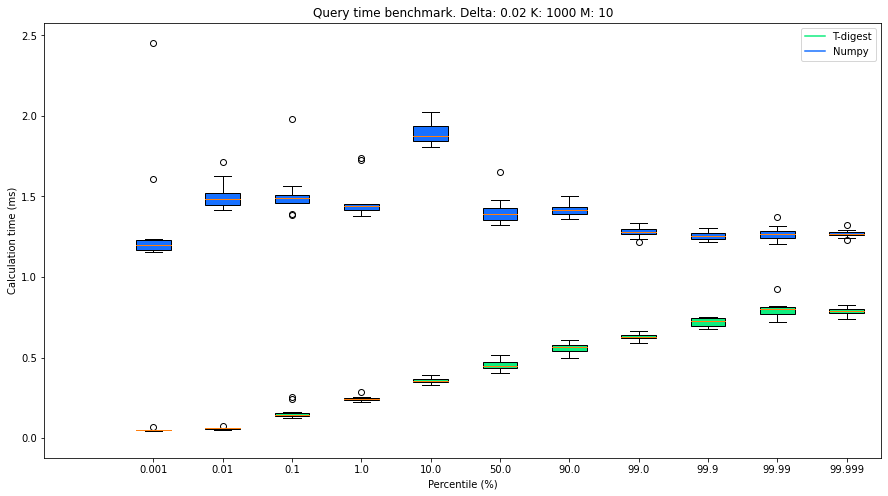

In [ ]:
#@title
data = np.random.random(size=100000)
percentiles = [0.001, 0.01, 0.1, 1.0, 10.0, 50.0, 90.0, 99.0, 99.9, 99.99, 99.999]
data_sizes = [10, 100, 1000, 10000, 100000, 500000]
delta = 0.02
K = 1000

errors = error_benchmark(data, percentiles, delta=delta, K=K)
digest_sizes = space_benchmark(data_sizes, delta=delta, K=K)
np_query_times, digest_query_times = percentile_query_time_benchmark(data, percentiles, delta=delta, K=K)

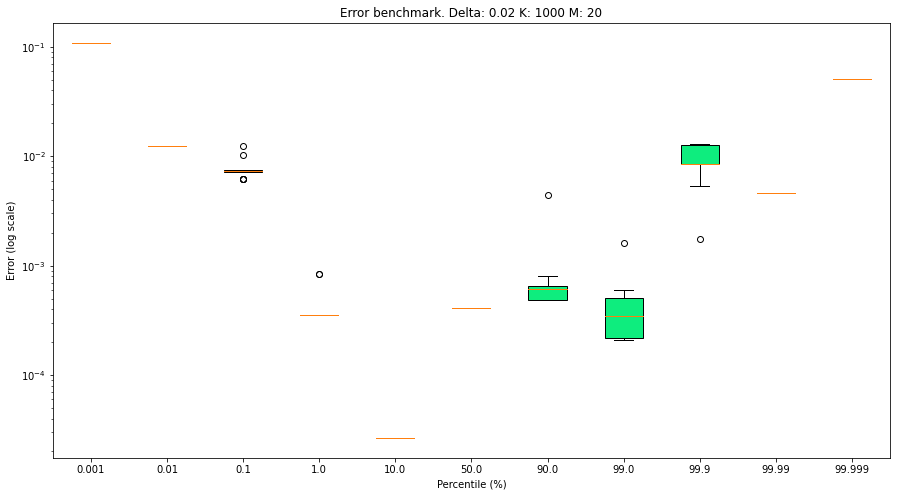

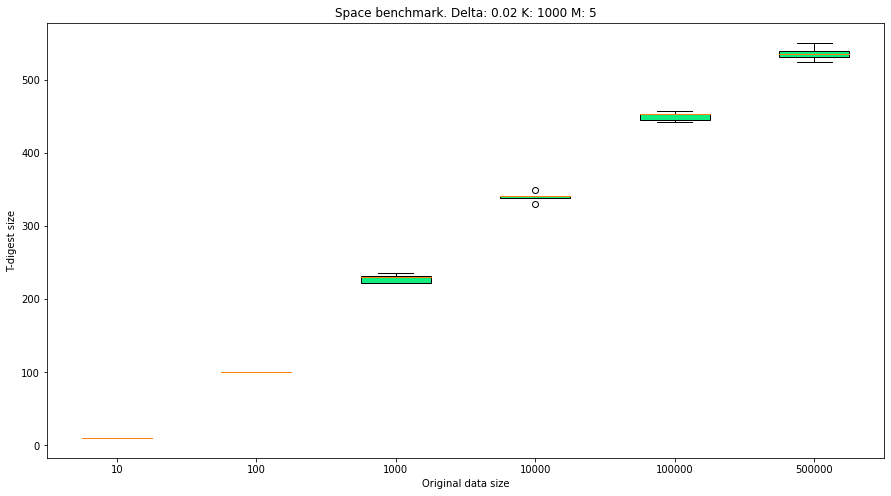

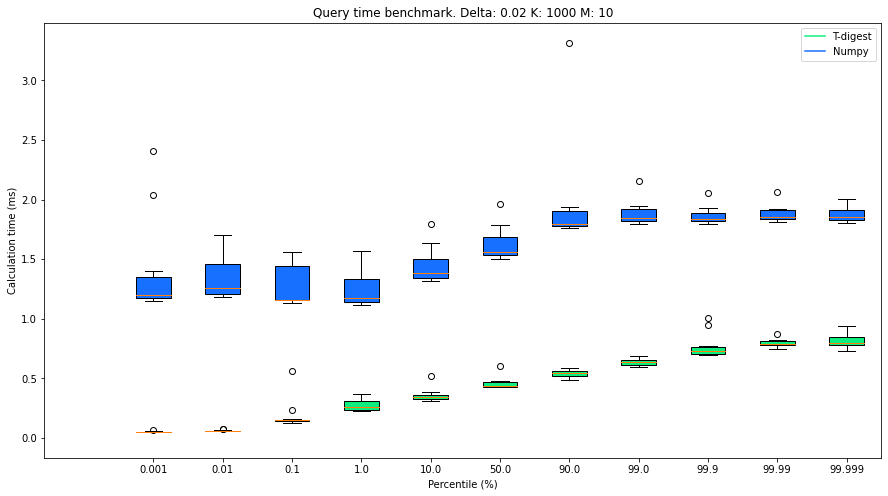

In [ ]:
#@title
data = np.random.normal(size=100000)
percentiles = [0.001, 0.01, 0.1, 1.0, 10.0, 50.0, 90.0, 99.0, 99.9, 99.99, 99.999]
data_sizes = [10, 100, 1000, 10000, 100000, 500000]
delta = 0.02
K = 1000

errors = error_benchmark(data, percentiles, delta=delta, K=K)
digest_sizes = space_benchmark(data_sizes, delta=delta, K=K)
np_query_times, digest_query_times = percentile_query_time_benchmark(data, percentiles, delta=delta, K=K)

# Conclusion

T-digest allows to parallelize quantile calculation, reduce space consumption logarithmically while maintaining a $10^{-4}$ error magnitude for uniformly distributed data. This is comparable to the results from the paper. In addition, T-digest maintained quantile query time above 1 ms for data size of order $10^5$

However, the error rate change has reversed for normally-distributed data, this is, probably, due to inappropriate scaling function and needs to be investigated further